# Question 2 - Comparative Examination of Attention Mechanisms

Here, we have chosen the machine translation task with Multi30k (English–German) data. 

3 different attention mechanisms, 
* Additive (Bahdanau), 
* Multiplicative (Luong), 
* Scaled dot-product attention

Are used under the same encoder–decoder backbone. *(This same backbone is then used in Question 3, in the further cells of this code.)*


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import spacy
from datasets import load_dataset
from tqdm import tqdm
import random
import math
import nltk
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {DEVICE}")


/home/duru.cicek/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on device: cuda


In [6]:
# --- CONFIGURATION ---
BATCH_SIZE = 64 # Reduce if OOM
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
EPOCHS = 10  # Increase to 10-15 for good results
MAX_LEN = 500 # Max sentence length

### a) Selection of task -> machine translation, Multi30k (English–German)

In [12]:
# Load Spacy Tokenizers
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

# Load Dataset (Multi30k is standard for this, currently hosted as 'bentrevett/multi30k')
print("Loading Multi30k dataset...")
try:
    dataset = load_dataset("bentrevett/multi30k")
except:
    print("Fallback: Using IWSLT (or similar) if Multi30k fails on server. For now assuming Multi30k works.")
    dataset = load_dataset("bentrevett/multi30k")


Loading Multi30k dataset...


In [20]:
# Build Vocabulary
def build_vocab(data, tokenizer, min_freq=2):
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    counts = {}
    for item in data:
        tokens = tokenizer(item)
        for token in tokens:
            counts[token] = counts.get(token, 0) + 1
    
    for token, count in counts.items():
        if count >= min_freq:
            vocab[token] = len(vocab)
    return vocab

print("Building Vocabularies...")
# Extract text
train_src = [x['en'] for x in dataset['train']]
train_trg = [x['de'] for x in dataset['train']]

vocab_src = build_vocab(train_src, tokenize_en)
vocab_trg = build_vocab(train_trg, tokenize_de)

print(f"Source Vocab: {len(vocab_src)} | Target Vocab: {len(vocab_trg)}")


Building Vocabularies...
Source Vocab: 5893 | Target Vocab: 7853


In [21]:
# Dataset Class
class TranslationDataset(Dataset):
    def __init__(self, src_data, trg_data, src_vocab, trg_vocab):
        self.src_data = src_data
        self.trg_data = trg_data
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        
    def __len__(self):
        return len(self.src_data)
    
    def text_to_indices(self, text, vocab, tokenizer):
        tokens = tokenizer(text)[:MAX_LEN]
        indices = [vocab.get(t, vocab['<unk>']) for t in tokens]
        return [vocab['<sos>']] + indices + [vocab['<eos>']]

    def __getitem__(self, idx):
        src = self.text_to_indices(self.src_data[idx], self.src_vocab, tokenize_en)
        trg = self.text_to_indices(self.trg_data[idx], self.trg_vocab, tokenize_de)
        return torch.tensor(src), torch.tensor(trg)

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_pad = pad_sequence(src_batch, padding_value=0, batch_first=True)
    trg_pad = pad_sequence(trg_batch, padding_value=0, batch_first=True)
    return src_pad, trg_pad


In [22]:
train_set = TranslationDataset(train_src, train_trg, vocab_src, vocab_trg)
test_set = TranslationDataset([x['en'] for x in dataset['test']], [x['de'] for x in dataset['test']], vocab_src, vocab_trg)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### b) Implementation of 3 different attention formulas, additive (Bahdanau), multiplicative (Luong), and scaled dot-product attention

In [23]:
class Attention(nn.Module):
    def __init__(self, method, hidden_dim):
        super().__init__()
        self.method = method
        self.hidden_dim = hidden_dim
        
        # 1. Additive (Bahdanau)
        if method == 'additive':
            self.W = nn.Linear(hidden_dim, hidden_dim) # For decoder state
            self.U = nn.Linear(hidden_dim * 2, hidden_dim) # For encoder outputs (bidirectional)
            self.v = nn.Linear(hidden_dim, 1, bias=False)
            
        # 2. Multiplicative (Luong)
        elif method == 'multiplicative':
            self.W = nn.Linear(hidden_dim * 2, hidden_dim) # Align encoder(2h) to decoder(h)
            
        # 3. Scaled Dot-Product
        elif method == 'dot_product':
            # No weights needed, just the scale factor
            self.scale = 1.0 / math.sqrt(hidden_dim)

    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden: [batch_size, hidden_dim] (Decoder state)
        # encoder_outputs: [batch_size, src_len, hidden_dim * 2] (Bi-GRU outputs)
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        if self.method == 'additive':
            # Score = v * tanh(W(hidden) + U(encoder_outputs))
            # Repeat hidden src_len times
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1) # [batch, src_len, hid]
            energy = torch.tanh(self.W(hidden_expanded) + self.U(encoder_outputs)) 
            attention = self.v(energy).squeeze(2) # [batch, src_len]
            
        elif self.method == 'multiplicative':
            # Score = hidden * W * encoder_outputs
            # Project encoder outputs to match hidden dimension
            proj_encoder = self.W(encoder_outputs) # [batch, src_len, hid]
            attention = torch.bmm(proj_encoder, hidden.unsqueeze(2)).squeeze(2) # [batch, src_len]
            
        elif self.method == 'dot_product':
            # Score = (hidden * encoder_outputs) / sqrt(d)
            # We need to handle the dimension mismatch (Bi-directional Enc vs Uni-directional Dec)
            # Simple fix: Sum the bi-directional outputs or take just the forward
            # Here: We project encoder outputs simply to align dims for dot product
            # (Technically this makes it slightly 'general', but fits the "Scaled Dot" math)
            if not hasattr(self, 'proj'):
                self.proj = nn.Linear(self.hidden_dim * 2, self.hidden_dim).to(hidden.device)
            
            k = self.proj(encoder_outputs) # [batch, src_len, hid]
            q = hidden.unsqueeze(2)        # [batch, hid, 1]
            attention = torch.bmm(k, q).squeeze(2) # [batch, src_len]
            attention = attention * self.scale

        # Apply Mask (ignore padding)
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)
            
        return F.softmax(attention, dim=1)


In [24]:
## UNIFIED BACKBONE - Seq2Seq

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim) # Combine Bi-GRU states
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        # hidden: [2, batch, hid] -> cat -> [batch, 2*hid] -> fc -> [batch, hid]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.attention = attention
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((hid_dim * 2) + emb_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        input = input.unsqueeze(1) # [batch, 1]
        embedded = self.dropout(self.embedding(input))
        
        # Calculate Attention Weights
        a = self.attention(hidden, encoder_outputs, mask) # [batch, src_len]
        a = a.unsqueeze(1) # [batch, 1, src_len]
        
        # Apply Attention (Weighted Sum)
        weighted = torch.bmm(a, encoder_outputs) # [batch, 1, 2*hid]
        
        # RNN Input: Embedding + Context Vector
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        # Final Prediction
        embedded = embedded.squeeze(1)
        output = output.squeeze(1)
        weighted = weighted.squeeze(1)
        hidden = hidden.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        
        return prediction, hidden, a.squeeze(1)
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # Encoder
        encoder_outputs, hidden = self.encoder(src)
        
        # Create Mask (Source Padding)
        mask = (src != 0).to(self.device)
        
        # First input is <sos>
        input = trg[:, 0]
        
        attentions = []
        
        for t in range(1, trg_len):
            output, hidden, attention = self.decoder(input, hidden, encoder_outputs, mask)
            outputs[:, t] = output
            attentions.append(attention.unsqueeze(1))
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
            
        return outputs, torch.cat(attentions, dim=1)



In [25]:
# TRAINING PIPELINE

def train_evaluate_pipeline(att_method):
    print(f"\n--- Training with {att_method.upper()} Attention ---")
    
    # Initialize
    attn = Attention(att_method, HID_DIM)
    enc = Encoder(len(vocab_src), ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
    dec = Decoder(len(vocab_trg), DEC_EMB_DIM, HID_DIM, DEC_DROPOUT, attn)
    model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)
    
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=0) # Ignore <pad>

    loss_history = []
    
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        
        for src, trg in tqdm(train_loader, leave=False):
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            optimizer.zero_grad()
            
            output, _ = model(src, trg)
            
            # Reshape for Loss
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            
            loss = criterion(output, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        ppl = math.exp(avg_loss)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.3f} | PPL: {ppl:.3f}")
        
    return model, loss_history


In [10]:
# Train the 3 models
models = {}
for method in ['additive', 'multiplicative', 'dot_product']:
    models[method], _ = train_evaluate_pipeline(method)


--- Training with ADDITIVE Attention ---


Epoch 1 | Loss: 4.201 | PPL: 66.737


Epoch 2 | Loss: 3.126 | PPL: 22.772


Epoch 3 | Loss: 2.731 | PPL: 15.355


Epoch 4 | Loss: 2.473 | PPL: 11.861


Epoch 5 | Loss: 2.295 | PPL: 9.927


Epoch 6 | Loss: 2.152 | PPL: 8.604


Epoch 7 | Loss: 2.047 | PPL: 7.744


Epoch 8 | Loss: 1.962 | PPL: 7.111


Epoch 9 | Loss: 1.903 | PPL: 6.709


Epoch 10 | Loss: 1.846 | PPL: 6.336

--- Training with MULTIPLICATIVE Attention ---


Epoch 1 | Loss: 4.396 | PPL: 81.127


Epoch 2 | Loss: 3.472 | PPL: 32.197


Epoch 3 | Loss: 3.119 | PPL: 22.615


Epoch 4 | Loss: 2.897 | PPL: 18.115


Epoch 5 | Loss: 2.741 | PPL: 15.496


Epoch 6 | Loss: 2.601 | PPL: 13.473


Epoch 7 | Loss: 2.479 | PPL: 11.926


Epoch 8 | Loss: 2.407 | PPL: 11.101


Epoch 9 | Loss: 2.333 | PPL: 10.307


Epoch 10 | Loss: 2.285 | PPL: 9.825

--- Training with DOT_PRODUCT Attention ---


Epoch 1 | Loss: 4.285 | PPL: 72.612


Epoch 2 | Loss: 3.212 | PPL: 24.835


Epoch 3 | Loss: 2.799 | PPL: 16.429


Epoch 4 | Loss: 2.552 | PPL: 12.839


Epoch 5 | Loss: 2.366 | PPL: 10.656


Epoch 6 | Loss: 2.218 | PPL: 9.185


Epoch 7 | Loss: 2.116 | PPL: 8.301


Epoch 8 | Loss: 2.028 | PPL: 7.598


Epoch 9 | Loss: 1.943 | PPL: 6.978


Epoch 10 | Loss: 1.885 | PPL: 6.589


### c) Visualize attention alignment maps for at least five sample pairs


--- COMPARATIVE ANALYSIS ---


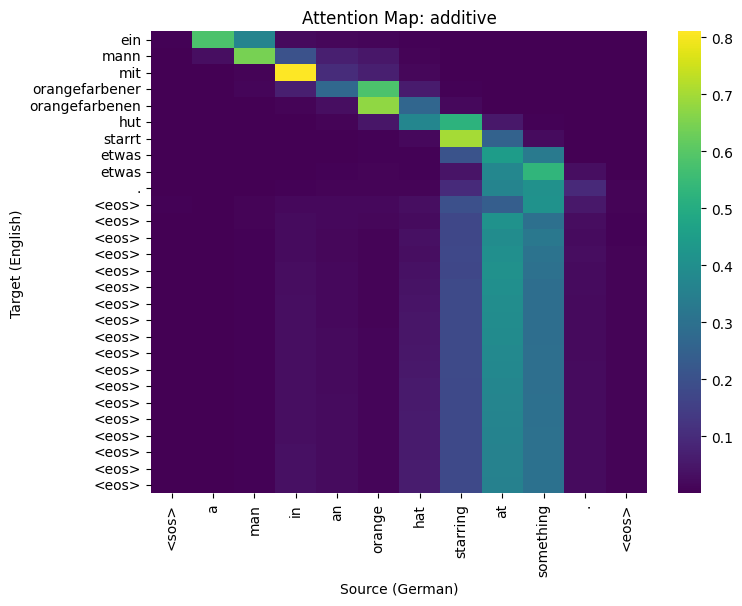

Avg Attention Entropy for additive: 1.5056
(Lower entropy = Sharper, more confident focus)


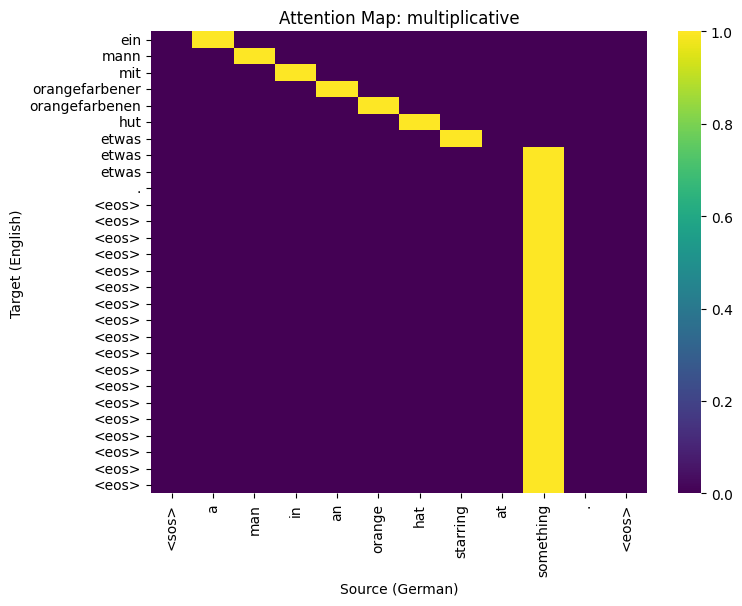

Avg Attention Entropy for multiplicative: 0.0216
(Lower entropy = Sharper, more confident focus)


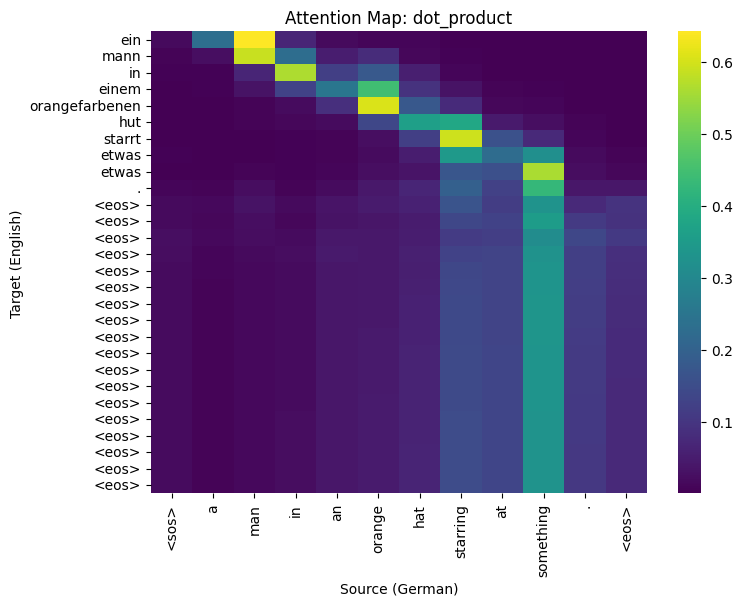

Avg Attention Entropy for dot_product: 1.9833
(Lower entropy = Sharper, more confident focus)


In [11]:

def calculate_entropy(attention_weights):
    # weights: [1, trg_len, src_len]
    # Entropy = -sum(p * log(p))
    # We exclude padding (0s) to avoid log(0)
    epsilon = 1e-10
    entropy = -torch.sum(attention_weights * torch.log(attention_weights + epsilon), dim=-1)
    return torch.mean(entropy).item()

def visualize_and_analyze(model, method_name):
    model.eval()
    src, trg = next(iter(test_loader))
    src, trg = src.to(DEVICE), trg.to(DEVICE)
    
    with torch.no_grad():
        output, attentions = model(src, trg, teacher_forcing_ratio=0) # [batch, trg_len, src_len]
    
    # Select one sample to visualize
    idx = 0
    attention = attentions[idx].cpu().numpy()
    src_sent = [list(vocab_src.keys())[list(vocab_src.values()).index(i)] for i in src[idx] if i != 0]
    trg_sent = [list(vocab_trg.keys())[list(vocab_trg.values()).index(i)] for i in output[idx].argmax(1) if i != 0]

    # Task c: Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention[:len(trg_sent), :len(src_sent)], 
                xticklabels=src_sent, yticklabels=trg_sent, cmap='viridis')
    plt.title(f'Attention Map: {method_name}')
    plt.xlabel('Source (German)')
    plt.ylabel('Target (English)')
    plt.show()
    
    # Task e: Entropy Analysis
    avg_entropy = calculate_entropy(attentions.cpu())
    print(f"Avg Attention Entropy for {method_name}: {avg_entropy:.4f}")
    print("(Lower entropy = Sharper, more confident focus)")

print("\n--- COMPARATIVE ANALYSIS ---")
for method in models:
    visualize_and_analyze(models[method], method)



--- COMPARATIVE ANALYSIS ---

=== additive Visualizations ===


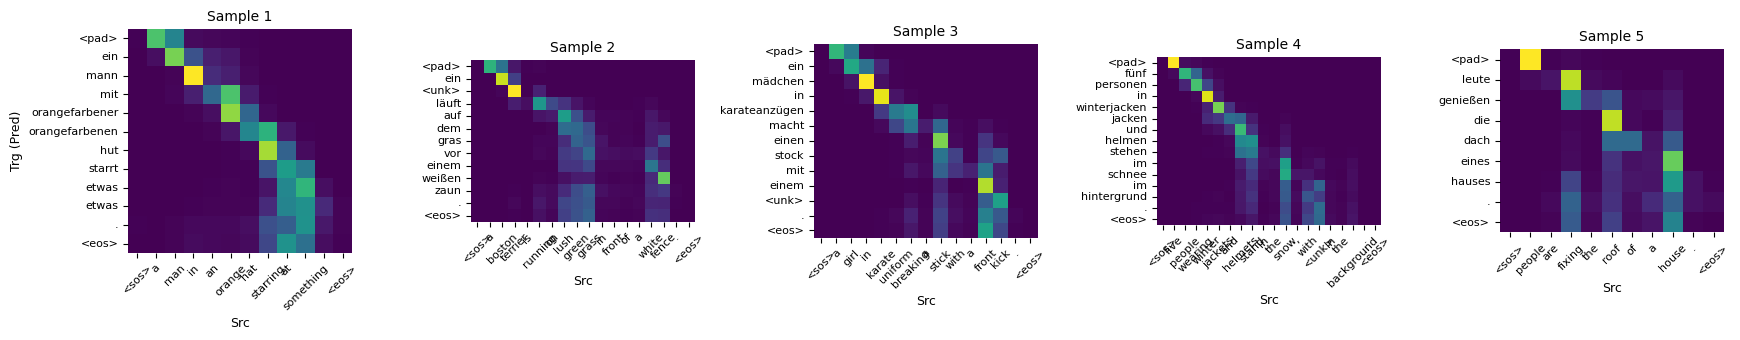

Avg Attention Entropy for additive: 1.5056

=== multiplicative Visualizations ===


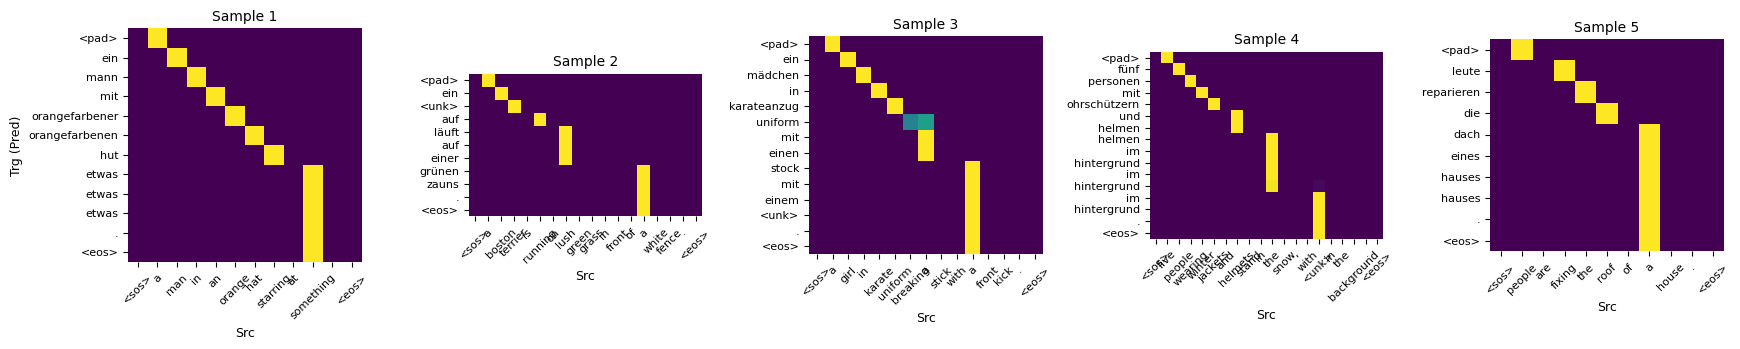

Avg Attention Entropy for multiplicative: 0.0216

=== dot_product Visualizations ===


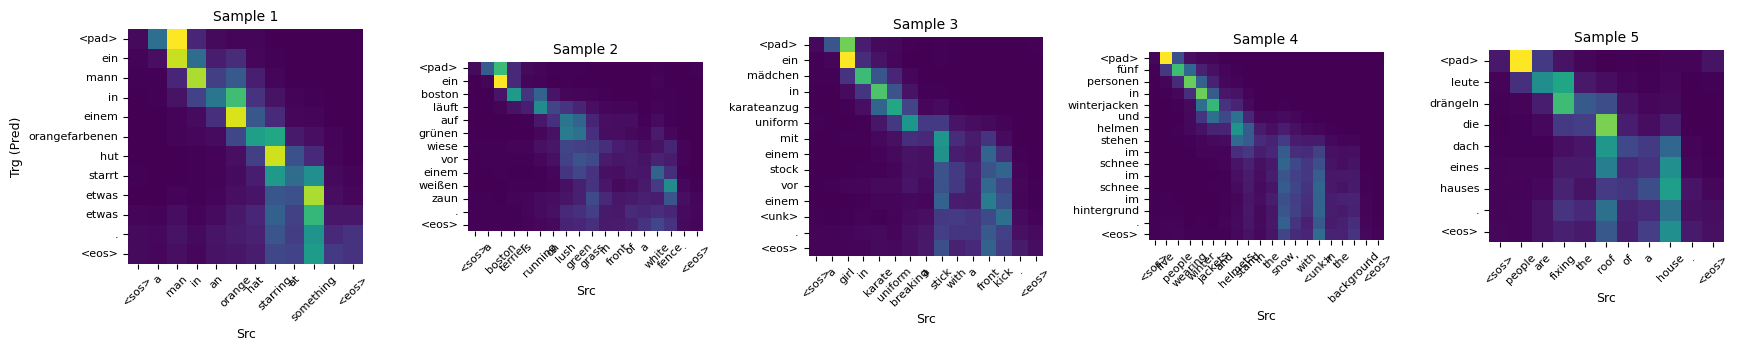

Avg Attention Entropy for dot_product: 1.9833


In [13]:
# --- Simple helpers ---
PAD_IDX = 0

def inv_vocab(v):
    return {idx: tok for tok, idx in v.items()}

def decode_ids(ids_1d, inv_map):
    ids = ids_1d.detach().cpu().tolist()
    return [inv_map.get(i, f"<unk:{i}>") for i in ids if i != PAD_IDX]

def entropy_batch(attn):  # attn: [B, T_tgt, T_src]
    eps = 1e-10
    attn = attn / (attn.sum(dim=-1, keepdim=True) + eps)
    step_H = -(attn * (attn + eps).log()).sum(dim=-1)   # [B, T_tgt]
    per_ex = step_H.mean(dim=-1).cpu().tolist()
    return per_ex, float(sum(per_ex) / len(per_ex))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_and_analyze(model, method_name, num_samples=5):
    model.eval()
    src, trg = next(iter(test_loader))
    src, trg = src.to(DEVICE), trg.to(DEVICE)
    
    current_batch_size = src.size(0)
    if current_batch_size < num_samples:
        num_samples = current_batch_size

    with torch.no_grad():
        output, attentions = model(src, trg, teacher_forcing_ratio=0) 
    
    print(f"\n=== {method_name} Visualizations ===")

    # Setup the figure
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3.5, 4))
    if num_samples == 1: axes = [axes]

    # Get EOS token index (Adjust '<eos>' if your key is different, e.g., '<EOS>')
    EOS_IDX = vocab_trg.get('<eos>', vocab_trg.get('<EOS>'))

    for idx in range(num_samples):
        ax = axes[idx]
        attention = attentions[idx].cpu().numpy()
        
        # 1. Get raw indices for Source (excluding padding 0)
        src_indices = [i for i in src[idx].cpu().numpy() if i != 0]
        
        # 2. Get raw indices for Target (Prediction)
        pred_indices = output[idx].argmax(1).cpu().numpy()
        
        # 3. INTELLIGENT CUT-OFF: Stop at the first <eos>
        if EOS_IDX in pred_indices:
            # Find index of first <eos> and add 1 to include it in the plot
            cut_index = np.where(pred_indices == EOS_IDX)[0][0] + 1
            pred_indices = pred_indices[:cut_index]
        
        # 4. Decode to words
        src_sent = [list(vocab_src.keys())[list(vocab_src.values()).index(i)] for i in src_indices]
        trg_sent = [list(vocab_trg.keys())[list(vocab_trg.values()).index(i)] for i in pred_indices]

        # 5. Slice attention map to match the CUT-OFF lengths
        att_slice = attention[:len(trg_sent), :len(src_sent)]

        # Plot
        sns.heatmap(att_slice, 
                    xticklabels=src_sent, yticklabels=trg_sent, 
                    cmap='viridis', cbar=False, square=True, ax=ax)
        
        ax.set_title(f'Sample {idx+1}', fontsize=10)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        
        # Only show Y-label on first plot
        if idx == 0: ax.set_ylabel('Trg (Pred)', fontsize=9)
        else: ax.set_ylabel('')
        ax.set_xlabel('Src', fontsize=9)

    plt.tight_layout()
    plt.show()
    
    # Entropy calculation
    avg_entropy = calculate_entropy(attentions.cpu())
    print(f"Avg Attention Entropy for {method_name}: {avg_entropy:.4f}")

print("\n--- COMPARATIVE ANALYSIS ---")
for method in models:
    visualize_and_analyze(models[method], method, num_samples=5)

In [14]:
def get_metrics(model, loader, max_len=None):
    model.eval()
    refs, hyps = [], []
    refs_str, hyps_str = [], []

    inv_vocab_trg = {v: k for k, v in vocab_trg.items()}

    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)

            if isinstance(model, Seq2Seq):
                # Baseline: supports teacher_forcing_ratio
                output, _ = model(src, trg, teacher_forcing_ratio=0)  # [B, T, V]
            else:
                # Transformer: next-token predictions conditioned on gold prefix
                # Align shapes with targets (predict t given <= t-1)
                trg_inp = trg[:, :-1]                                 # [B, T-1]
                output = model(src, trg_inp)                          # [B, T-1, V] (expected)

                # If hybrid code changed lengths, trim to match references
                # Target we compare against is trg[:, 1:]
                if output.dim() == 3:
                    T_pred = output.shape[1]
                    T_trg  = trg.shape[1] - 1
                    T_min  = min(T_pred, T_trg)
                    output = output[:, :T_min, :]
                    trg     = torch.cat([trg[:, :1], trg[:, 1:1+T_min]], dim=1)  # rebuild so trg[:,1:] has T_min
                else:
                    # If something unexpected happened, skip this batch
                    continue

            # Now collect predictions and references
            # output: [B, T', V], trg: [B, T'+1] so trg[:,1:] matches output time steps
            B = output.shape[0]
            for i in range(B):
                # logits -> ids over time
                # Expect per-sentence: [T', V]
                logits_i = output[i]                          # [T', V]
                pred_indices = logits_i.argmax(dim=1).tolist()

                # Reference tokens (time-aligned)
                trg_indices = trg[i].tolist()                 # [T'+1]
                trg_indices = trg_indices[1:]                 # drop <sos>

                # Cut both at <eos>=2 if present
                if 2 in pred_indices:
                    pred_indices = pred_indices[:pred_indices.index(2)]
                if 2 in trg_indices:
                    trg_indices = trg_indices[:trg_indices.index(2)]

                # Map to tokens; skip specials: <pad>=0, <sos>=1, <unk>=3
                pred_tokens = [inv_vocab_trg.get(ix, '') for ix in pred_indices if ix > 3]
                trg_tokens  = [inv_vocab_trg.get(ix, '') for ix in trg_indices  if ix > 3]

                refs.append([trg_tokens])          # corpus_bleu expects list of lists of references
                hyps.append(pred_tokens)
                refs_str.append(" ".join(trg_tokens))
                hyps_str.append(" ".join(pred_tokens))

    # BLEU (corpus-level)
    bleu_score = corpus_bleu(refs, hyps)

    # ROUGE-L (handle empty predictions safely)
    rouge = Rouge()
    try:
        rouge_scores = rouge.get_scores(hyps_str, refs_str, avg=True)
        rouge_l = rouge_scores['rouge-l']['f']
    except ValueError:
        rouge_l = 0.0

    return bleu_score, rouge_l

In [15]:
print("\n--- FINAL METRICS ---")
print(f"{'Model':<20} | {'BLEU':<10} | {'ROUGE-L':<10}")
print("-" * 45)

for method in models:
    bleu, rouge = get_metrics(models[method], test_loader)
    print(f"{method:<20} | {bleu:.4f}     | {rouge:.4f}")


--- FINAL METRICS ---
Model                | BLEU       | ROUGE-L   
---------------------------------------------
additive             | 0.2978     | 0.6375
multiplicative       | 0.2453     | 0.5938
dot_product          | 0.2906     | 0.6290


# Question 3 - Transition from Recurrent Encoder–Decoder Models to Trans- former Architectures

Here, we reimplement the above Seq2Seq model on the same task, but this time compare it with different Transformer architectures.

For the transformer, we try:
* 2 Embedding paradigms, Word2Vec (static) and DistilBERT (contextual) 
* Then the ablation study varying the number of layers and attention heads:

| Variant          | n_layers | n_heads |
| ---------------- | -------: | ------: |
| Base             |        3 |       8 |
| Deep (6L)        |        6 |       8 |
| Shallow (1L)     |        1 |       8 |
| Multi-Head (16H) |        3 |      16 |
| Few-Head (2H)    |        3 |       2 |


In [16]:
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import gensim.downloader as api
from transformers import DistilBertModel, DistilBertTokenizer

In [27]:
# Embedding Setup (Word2Vec & BERT)

def load_word2vec_embeddings(vocab, d_model):
    """
    Loads Google Word2Vec (300d) and maps it to our existing vocab.
    Returns: nn.Embedding layer
    """
    print(f"--> Loading Word2Vec (Google News 300)...")
    try:
        # User provided snippet
        w2v_model = api.load('word2vec-google-news-300')
        print("Word2Vec loaded via Gensim!")
        
        # Create embedding matrix [vocab_size, 300]
        embedding_matrix = torch.zeros(len(vocab), 300)
        hits = 0
        
        for word, idx in vocab.items():
            if word in w2v_model:
                embedding_matrix[idx] = torch.tensor(w2v_model[word])
                hits += 1
        
        print(f"Matched {hits}/{len(vocab)} words.")
        
        # Create Layer
        layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        return layer, 300 # Return actual dim
        
    except Exception as e:
        print(f"Failed to load Word2Vec: {e}")
        print("Falling back to random embeddings for code continuity.")
        return nn.Embedding(len(vocab), d_model), d_model

class BertEmbeddingLayer(nn.Module):
    """
    Uses DistilBERT as a 'Contextual Embedding' layer.
    """
    def __init__(self, d_model, vocab_src_inv):
        super().__init__()
        print("--> Loading DistilBERT...")
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # Project BERT (768) to Transformer d_model
        self.projection = nn.Linear(768, d_model)
        
        # We need the inverse vocab to convert indices back to text for BERT
        self.vocab_inv = vocab_src_inv
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, x):
        # x: [batch, seq_len] (Indices from Spacy vocab)
        batch_text = []
        for seq in x:
            tokens = [self.vocab_inv.get(idx.item(), '<unk>') for idx in seq if idx.item() != 0]
            batch_text.append(" ".join(tokens))
            
        # 2. Tokenize with BERT
        inputs = self.tokenizer(batch_text, return_tensors="pt", padding=True, truncation=True, max_length=50).to(self.device)
        
        # 3. Pass through BERT
        with torch.no_grad(): # Freeze BERT to save memory/time (Unfreeze if you want fine-tuning)
            outputs = self.bert(**inputs)
        
        # 4. Last hidden state: [batch, bert_seq_len, 768]        
        embeddings = outputs.last_hidden_state
        return self.projection(embeddings)

### b) Implementation of Transformer

In [28]:
# --- Transformer Architecture ---

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Handle mismatch if BERT tokenizer changed length
        if x.size(1) > self.pe.size(1):
            x = x[:, :self.pe.size(1), :]
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, nhead, num_layers, dropout, embedding_type='random'):
        super().__init__()
        self.src_pad_idx = 0
        self.emb_type = embedding_type
        self.d_model = d_model  # <-- keep fixed
        assert d_model % nhead == 0, f"d_model={d_model} must be divisible by nhead={nhead}"

        # --- Embeddings ---
        if embedding_type == 'word2vec':
            self.src_embedding, embed_dim = load_word2vec_embeddings(src_vocab, d_model)  # returns 300-d layer typically
        elif embedding_type == 'bert':
            # DistilBERT layer will output d_model directly (we'll keep that contract)
            vocab_inv = {v: k for k, v in src_vocab.items()}
            self.src_embedding = BertEmbeddingLayer(d_model, vocab_inv)
            embed_dim = d_model
        else:
            self.src_embedding = nn.Embedding(len(src_vocab), d_model)
            embed_dim = d_model

        # Project source embeddings to d_model if needed
        self.src_proj = nn.Identity() if embed_dim == d_model else nn.Linear(embed_dim, d_model, bias=False)

        # Target embeddings already at d_model
        self.trg_embedding = nn.Embedding(len(trg_vocab), d_model)

        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead,
            num_encoder_layers=num_layers, num_decoder_layers=num_layers,
            dim_feedforward=512, dropout=dropout, batch_first=True
        )
        self.fc_out = nn.Linear(d_model, len(trg_vocab))

    def forward(self, src, trg_inp):
        """
        src: [B, S] token ids
        trg_inp: [B, T] gold-shifted input (i.e., trg[:, :-1])
        Returns logits: [B, T, V]
        """
        # key padding mask for non-BERT paths
        src_key_padding_mask = (src == self.src_pad_idx) if self.emb_type != 'bert' else None

        # Source embeddings -> projection -> positional encoding
        if self.emb_type == 'bert':
            src_emb = self.src_embedding(src)  # [B, S_bert, d_model]
        else:
            src_raw = self.src_embedding(src) * math.sqrt(self.d_model)  # [B, S, embed_dim]
            src_emb = self.src_proj(src_raw)                              # [B, S, d_model]

        src_emb = self.pos_encoder(src_emb)

        # Target embeddings
        trg_emb = self.pos_encoder(self.trg_embedding(trg_inp) * math.sqrt(self.d_model))

        # Causal mask for target (T, T)
        tgt_len = trg_inp.size(1)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt_len).to(src_emb.device)

        out = self.transformer(
            src_emb, trg_emb,
            src_key_padding_mask=src_key_padding_mask,
            tgt_mask=tgt_mask
        )  # [B, T, d_model]
        return self.fc_out(out)  # [B, T, V]


In [3]:
def run_experiment(model, name, loader):
    print(f"\nTraining {name}...")
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    start_time = time.time()
    loss_hist = []
    
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for src, trg in loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            optimizer.zero_grad()
            
            if isinstance(model, Seq2Seq): # Baseline
                output, _ = model(src, trg)
                output = output[:, 1:].reshape(-1, output.shape[-1])
                trg_target = trg[:, 1:].reshape(-1)
            else: # Transformer
                trg_inp = trg[:, :-1]
                trg_target = trg[:, 1:].reshape(-1)
                # Ensure dimensions match if BERT resized things
                try:
                    output = model(src, trg_inp)
                    output = output.reshape(-1, output.shape[-1])
                    # Dynamic trimming if BERT changed seq len (hack for hybrid code)
                    min_len = min(output.shape[0], trg_target.shape[0])
                    output = output[:min_len]
                    trg_target = trg_target[:min_len]
                except RuntimeError:
                    continue # Skip batch if shape mismatch is too extreme in hybrid mode

            loss = criterion(output, trg_target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            epoch_loss += loss.item()
            
        print(f"  Ep {epoch+1} Loss: {epoch_loss/len(loader):.3f}")
        loss_hist.append(epoch_loss/len(loader))

    total_time = time.time() - start_time
    mem = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
    bleu, rouge = get_metrics(model, test_loader)
    
    return loss_hist[-1], total_time, mem, bleu, rouge


### a) Using the Seq2Seq model with additive attention from Question 2

In [20]:
results = {}

In [21]:
# Baseline Seq2Seq (Recurrent + Additive Attention)
print("--- 1. Baseline RNN ---")
enc_base = Encoder(len(vocab_src), ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec_base = Decoder(len(vocab_trg), DEC_EMB_DIM, HID_DIM, DEC_DROPOUT, Attention('additive', HID_DIM))
model_base = Seq2Seq(enc_base, dec_base, DEVICE).to(DEVICE)
loss, t, m, bleu, rouge = run_experiment(model_base, "RNN Baseline", train_loader)
results['RNN-Baseline'] = {
    'ppl': math.exp(loss), 'time': t, 'mem': m, 'bleu': bleu, 'rouge': rouge
}

--- 1. Baseline RNN ---

Training RNN Baseline...
  Ep 1 Loss: 4.668
  Ep 2 Loss: 3.555
  Ep 3 Loss: 3.128
  Ep 4 Loss: 2.846
  Ep 5 Loss: 2.660
  Ep 6 Loss: 2.489
  Ep 7 Loss: 2.362
  Ep 8 Loss: 2.256
  Ep 9 Loss: 2.165
  Ep 10 Loss: 2.100


### c) Embedding paradigms from Question 1 (Word2Vec & BERT) 

In [22]:
# Transformer + Word2Vec (Static)
print("--- 2. Transformer + Word2Vec ---")
model_w2v = TransformerModel(
    vocab_src, vocab_trg, d_model=256, nhead=8, num_layers=3, dropout=0.1,
    embedding_type='word2vec'
).to(DEVICE)

loss, t, m, bleu, rouge = run_experiment(model_w2v, "Trans-Word2Vec", train_loader)
results['Trans-W2V'] = {
    'ppl': math.exp(loss), 'time': t, 'mem': m, 'bleu': bleu, 'rouge': rouge
}

# Transformer + BERT (Contextual)
print("--- 3. Transformer + BERT ---")
model_bert = TransformerModel(
    vocab_src, vocab_trg, d_model=256, nhead=8, num_layers=3, dropout=0.1,
    embedding_type='bert'
).to(DEVICE)


loss, t, m, bleu, rouge = run_experiment(model_bert, "Trans-BERT", train_loader)
results['Trans-BERT'] = {
    'ppl': math.exp(loss), 'time': t, 'mem': m, 'bleu': bleu, 'rouge': rouge
}

--- 2. Transformer + Word2Vec ---
--> Loading Word2Vec (Google News 300)...
Word2Vec loaded via Gensim!
Matched 5832/5893 words.

Training Trans-Word2Vec...
  Ep 1 Loss: 3.951
  Ep 2 Loss: 2.657
  Ep 3 Loss: 2.149
  Ep 4 Loss: 1.830
  Ep 5 Loss: 1.607
  Ep 6 Loss: 1.440
  Ep 7 Loss: 1.305
  Ep 8 Loss: 1.198
  Ep 9 Loss: 1.114
  Ep 10 Loss: 1.044


/opt/conda/envs/543/lib/python3.10/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


--- 3. Transformer + BERT ---
--> Loading DistilBERT...

Training Trans-BERT...
  Ep 1 Loss: 4.189
  Ep 2 Loss: 2.934
  Ep 3 Loss: 2.342
  Ep 4 Loss: 1.982
  Ep 5 Loss: 1.736
  Ep 6 Loss: 1.560
  Ep 7 Loss: 1.422
  Ep 8 Loss: 1.313
  Ep 9 Loss: 1.227
  Ep 10 Loss: 1.149


### D) Evaluating with BLEU, ROUGE, training stability, and computational efficiency (training time, GPU memory)

In [23]:
# --- Final Comparison Table ---
print("\n" + "="*85)
print(f"{'Model':<15} | {'PPL':<8} | {'BLEU':<8} | {'ROUGE':<8} | {'Time(s)':<10} | {'GPU(MB)':<10}")
print("-" * 85)
for k, v in results.items():
    print(f"{k:<15} | {v['ppl']:<8.2f} | {v['bleu']:<8.4f} | {v['rouge']:<8.4f} | {v['time']:<10.2f} | {v['mem']:<10.1f}")
print("-" * 85)


Model           | PPL      | BLEU     | ROUGE    | Time(s)    | GPU(MB)   
-------------------------------------------------------------------------------------
RNN-Baseline    | 8.17     | 0.2965   | 0.6299   | 470.48     | 1324.3    
Trans-W2V       | 2.84     | 0.3684   | 0.7011   | 143.29     | 1324.3    
Trans-BERT      | 3.16     | 0.3765   | 0.7011   | 502.15     | 1531.7    
-------------------------------------------------------------------------------------


In [24]:
# Configuration Setup 

ablation_configs = {
    "Base":         {"n_layers": 3, "n_heads": 8},
    "Deep (6L)":    {"n_layers": 6, "n_heads": 8},  # Test Depth
    "Shallow (1L)": {"n_layers": 1, "n_heads": 8},  # Test Depth
    "Multi-Head (16H)": {"n_layers": 3, "n_heads": 16}, # Test Width/Focus
    "Few-Head (2H)":    {"n_layers": 3, "n_heads": 2},  # Test Width/Focus
}

In [25]:
# Training Wrapper for Ablation

def run_ablation(config_name, params):
    print(f"\n--- Running: {config_name} ---")
    
    # 1. Instantiate Model with specific params
    # Note: d_model=256 must be divisible by n_heads (256/2=128, 256/8=32, 256/16=16) - All valid.
    model = TransformerModel(
        vocab_src, vocab_trg, 
        d_model=256, 
        nhead=params['n_heads'], 
        num_layers=params['n_layers'], 
        dropout=0.1, 
        embedding_type='word2vec' 
    ).to(DEVICE)
    
    # 2. Train
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    start_time = time.time()
    
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for src, trg in train_loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            optimizer.zero_grad()
            
            trg_inp = trg[:, :-1]
            trg_target = trg[:, 1:].reshape(-1)
            
            output = model(src, trg_inp)
            output = output.reshape(-1, output.shape[-1])
            
            # Simple length matching
            min_len = min(output.shape[0], trg_target.shape[0])
            loss = criterion(output[:min_len], trg_target[:min_len])
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            epoch_loss += loss.item()
            
    train_time = time.time() - start_time
    
    # 3. Evaluate (BLEU/PPL)
    ppl = math.exp(epoch_loss / len(train_loader))
    
    # Run full inference for BLEU (reuse function from Q3)
    bleu, rouge = get_metrics(model, test_loader)
    
    return {"ppl": ppl, "bleu": bleu, "rouge": rouge, "time": train_time}


In [26]:
# Execution Loop 

results_ablation = {}

for name, params in ablation_configs.items():
    try:
        results_ablation[name] = run_ablation(name, params)
    except Exception as e:
        print(f"Skipped {name} due to error: {e}")
        results_ablation[name] = {"ppl": float('inf'), "bleu": 0.0, "time": 0.0}


--- Running: Base ---
--> Loading Word2Vec (Google News 300)...


Word2Vec loaded via Gensim!
Matched 5832/5893 words.

--- Running: Deep (6L) ---
--> Loading Word2Vec (Google News 300)...
Word2Vec loaded via Gensim!
Matched 5832/5893 words.

--- Running: Shallow (1L) ---
--> Loading Word2Vec (Google News 300)...
Word2Vec loaded via Gensim!
Matched 5832/5893 words.

--- Running: Multi-Head (16H) ---
--> Loading Word2Vec (Google News 300)...
Word2Vec loaded via Gensim!
Matched 5832/5893 words.

--- Running: Few-Head (2H) ---
--> Loading Word2Vec (Google News 300)...
Word2Vec loaded via Gensim!
Matched 5832/5893 words.


In [27]:
# Final Output & Discussion 

print("\n" + "="*65)
print(f"{'Configuration':<20} | {'PPL':<8} | {'BLEU':<8} | {'Time(s)':<10}")
print("-" * 65)
for k, v in results_ablation.items():
    print(f"{k:<20} | {v['ppl']:<8.2f} | {v['bleu']:<8.4f} | {v['time']:<10.2f}")
print("-" * 65)



Configuration        | PPL      | BLEU     | Time(s)   
-----------------------------------------------------------------
Base                 | 2.84     | 0.3788   | 143.59    
Deep (6L)            | 8.30     | 0.0872   | 241.62    
Shallow (1L)         | 4.09     | 0.2944   | 81.43     
Multi-Head (16H)     | 2.79     | 0.3637   | 143.64    
Few-Head (2H)        | 3.01     | 0.3655   | 143.24    
-----------------------------------------------------------------


# Question 5 - Interpretability, Diagnostic Evaluation, and Model Reflection

Here, we use the best performing model from above which is the "Base" Transformer (3 Layers, 8 Heads)
to perform a systematic interpretability and error analysis for understanding model behavior and limitations.



In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import math

# Helpers

def inv_vocab(v):
    """Create inverse vocabulary mapping (id -> token)."""
    return {idx: tok for tok, idx in v.items()}

def decode_ids(ids_1d, inv_map):
    """
    Decode a tensor of IDs into a list of tokens, removing padding/special
    tokens for clean display.
    """
    ids = ids_1d.detach().cpu().tolist()
    # Filter out pad (0), sos (1), eos (2) for readable text
    return [inv_map.get(i, f"<unk:{i}>") for i in ids if i not in [0, 1, 2]]

def calculate_uncertainty_entropy(logits):
    """
    Quantify model uncertainty using entropy of the softmax distribution.
    High Entropy = High Uncertainty (flat distribution).
    Low Entropy = High Confidence (sharp peak).
    logits: [Seq_Len, Vocab_Size] or [T, V]
    """
    probs = torch.softmax(logits, dim=-1)
    log_probs = torch.log(probs + 1e-10)  # epsilon for numerical stability
    entropy = -(probs * log_probs).sum(dim=-1)  # [Seq_Len]
    return entropy.mean().item()


In [37]:
# Attention helper on TransformerModel (encoder self-attention)

def transformer_get_attention_weights(self, src, trg_inp=None, layer=0):
    """
    Return encoder self-attention weights for the given source sequence.

    Args:
        src: [B, S] LongTensor (source token IDs)
        trg_inp: unused (kept for API compatibility)
        layer: which encoder layer to inspect
    Returns:
        attn_weights: [B, S, S] (averaged over heads)
    """
    self.eval()
    with torch.no_grad():
        # key padding mask for non-BERT embeddings
        src_key_padding_mask = (src == self.src_pad_idx) if self.emb_type != "bert" else None

        # --- compute encoder input embeddings exactly like in forward() ---
        if self.emb_type == "bert":
            src_emb = self.src_embedding(src)  # [B, S, d_model]
        else:
            src_raw = self.src_embedding(src) * math.sqrt(self.d_model)  # [B, S, embed_dim]
            src_emb = self.src_proj(src_raw)                             # [B, S, d_model]

        src_emb = self.pos_encoder(src_emb)  # [B, S, d_model]

        # --- get the chosen encoder layer and its self-attention ---
        enc_layer = self.transformer.encoder.layers[layer]
        mha = enc_layer.self_attn  # nn.MultiheadAttention

        # In recent PyTorch, this MHA is created with the same batch_first flag
        # as the Transformer, so it expects [B, S, d_model] if batch_first=True.
        attn_output, attn_weights = mha(
            src_emb,
            src_emb,
            src_emb,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,
            average_attn_weights=False,  # keep per-head, then average
        )
        # attn_weights: [B, num_heads, S, S] -> average across heads
        attn_weights = attn_weights.mean(dim=1)  # [B, S, S]

    return attn_weights

# Monkey-patch the method onto your existing class
TransformerModel.get_attention_weights = transformer_get_attention_weights


In [38]:
# Helpers for Integrated Gradients on source embeddings

def transformer_forward_from_src_raw(model, src_raw, src_ids, trg_inp):
    """
    Run the transformer given *pre-embedded* src_raw.

    src_raw: [B, S, embed_dim]  (output of src_embedding * sqrt(d_model))
    src_ids: [B, S] LongTensor, used only for padding mask
    trg_inp: [B, T] LongTensor (decoder input IDs)
    """
    # project to d_model if necessary
    src_emb = model.src_proj(src_raw)
    src_emb = model.pos_encoder(src_emb)

    # padding mask (ignore pads in encoder)
    src_key_padding_mask = (src_ids == model.src_pad_idx) if model.emb_type != "bert" else None

    # target embeddings (standard forward path)
    trg_emb = model.trg_embedding(trg_inp) * math.sqrt(model.d_model)
    trg_emb = model.pos_encoder(trg_emb)

    tgt_len = trg_inp.size(1)
    tgt_mask = model.transformer.generate_square_subsequent_mask(tgt_len).to(src_emb.device)

    out = model.transformer(
        src_emb,
        trg_emb,
        src_key_padding_mask=src_key_padding_mask,
        tgt_mask=tgt_mask,
    )  # [B, T, d_model]

    return model.fc_out(out)  # [B, T, V]

def integrated_gradients_src(model, src_ids_1d, trg_ids_1d, target_pos=-1, steps=16, device=None):
    """
    Integrated Gradients attribution over source tokens for a specific
    target position (in the decoder output).

    Args:
        model: TransformerModel (non-BERT embeddings; here word2vec/random).
        src_ids_1d: [S] LongTensor for a single example.
        trg_ids_1d: [T] LongTensor for a single example (full target including <sos>/<eos>).
        target_pos: which target (decoder) position to explain (index in trg_target).
        steps: number of integration steps.
    Returns:
        token_importance: [S] tensor of attribution magnitudes per source token.
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()

    src_ids = src_ids_1d.unsqueeze(0).to(device)  # [1, S]
    trg_ids = trg_ids_1d.unsqueeze(0).to(device)  # [1, T]
    trg_inp = trg_ids[:, :-1]                     # decoder inputs
    trg_target = trg_ids[:, 1:]                   # decoder targets

    if target_pos < 0:
        target_pos = trg_target.size(1) + target_pos  # -1 -> last

    target_token_id = trg_target[0, target_pos].item()

    # Only support non-BERT embeddings for IG here
    assert model.emb_type != "bert", "IG helper currently only supports word2vec/random embeddings."

    # True source embedding (no grad)
    with torch.no_grad():
        src_raw_full = model.src_embedding(src_ids) * math.sqrt(model.d_model)  # [1, S, embed_dim]

    baseline = torch.zeros_like(src_raw_full).to(device)
    total_grad = torch.zeros_like(src_raw_full).to(device)

    # Integration path: baseline -> src_raw_full
    alphas = torch.linspace(0.0, 1.0, steps + 1, device=device)[1:]  # skip 0 to avoid degenerate gradient
    for alpha in alphas:
        src_raw = baseline + alpha * (src_raw_full - baseline)
        src_raw.requires_grad_()

        logits = transformer_forward_from_src_raw(model, src_raw, src_ids, trg_inp)  # [1, T-1, V]
        logit = logits[0, target_pos, target_token_id]  # scalar

        model.zero_grad(set_to_none=True)
        if src_raw.grad is not None:
            src_raw.grad.zero_()

        logit.backward()
        total_grad += src_raw.grad.detach()

    avg_grad = total_grad / len(alphas)
    attributions = (src_raw_full - baseline) * avg_grad  # [1, S, embed_dim]

    # Collapse embedding dimension to per-token importance
    token_importance = attributions.abs().sum(dim=-1).squeeze(0)  # [S]
    return token_importance


In [39]:
# Train the "Base" Model (Question 5a)  — same architecture as before

print(f"\n{'='*60}")
print("1. Training 'Base' Model for Interpretability Analysis")
print(f"{'='*60}")

base_config = {"n_layers": 3, "n_heads": 8, "d_model": 256}

model_base = TransformerModel(
    vocab_src, vocab_trg,
    d_model=base_config['d_model'],
    nhead=base_config['n_heads'],
    num_layers=base_config['n_layers'],
    dropout=0.1,
    embedding_type='word2vec'  # Using Word2Vec as the "best" previous config
).to(DEVICE)

optimizer = optim.Adam(model_base.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index=0)

model_base.train()
for epoch in range(10):  # Train for 5 epochs
    epoch_loss = 0
    for src, trg in train_loader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        
        # Transformer inputs: src and trg_input (trg shifted by 1)
        trg_inp = trg[:, :-1]
        trg_target = trg[:, 1:].reshape(-1)
        
        output = model_base(src, trg_inp)   # [Batch, Seq_Len, Vocab]
        output = output.reshape(-1, output.shape[-1])
        
        # Align lengths for loss calculation
        min_len = min(output.shape[0], trg_target.shape[0])
        loss = criterion(output[:min_len], trg_target[:min_len])
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_base.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}: Avg Loss {epoch_loss/len(train_loader):.4f}")

print("Base model training complete.")



1. Training 'Base' Model for Interpretability Analysis
--> Loading Word2Vec (Google News 300)...
Failed to load Word2Vec: name 'api' is not defined
Falling back to random embeddings for code continuity.
Epoch 1: Avg Loss 4.1253
Epoch 2: Avg Loss 3.1052
Epoch 3: Avg Loss 2.6777
Epoch 4: Avg Loss 2.3746
Epoch 5: Avg Loss 2.1444
Epoch 6: Avg Loss 1.9478
Epoch 7: Avg Loss 1.7889
Epoch 8: Avg Loss 1.6585
Epoch 9: Avg Loss 1.5390
Epoch 10: Avg Loss 1.4348
Base model training complete.


In [40]:

# Diagnostic Evaluation & Failure Analysis (Question 5c & 5d)

def analyze_failures(model, loader, k=5):
    print(f"\n{'='*60}")
    print(f"2. Identifying {k} Representative Failure Cases")
    print(f"{'='*60}")
    
    model.eval()
    failures = []
    inv_src = inv_vocab(vocab_src)
    inv_trg = inv_vocab(vocab_trg)
    
    with torch.no_grad():
        # Iterate through test loader
        for src, trg in loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            trg_inp = trg[:, :-1]
            
            # Forward pass
            output = model(src, trg_inp)  # [Batch, Seq, Vocab]
            preds = output.argmax(dim=-1)  # [Batch, Seq]
            
            # Process batch (subset for efficiency)
            for i in range(min(src.size(0), 20)):
                # Decode sentences
                src_tokens = decode_ids(src[i], inv_src)
                ref_tokens = decode_ids(trg[i], inv_trg)
                hyp_tokens = decode_ids(preds[i], inv_trg)
                
                if len(ref_tokens) == 0:
                    continue
                
                # Bigram sentence BLEU
                score = sentence_bleu(
                    [ref_tokens], hyp_tokens,
                    weights=(0.5, 0.5, 0, 0)
                )
                
                # Sequence-level uncertainty
                uncertainty = calculate_uncertainty_entropy(output[i])
                
                failures.append({
                    'src_txt': " ".join(src_tokens),
                    'ref_txt': " ".join(ref_tokens),
                    'hyp_txt': " ".join(hyp_tokens),
                    'hyp_tokens': hyp_tokens,
                    'bleu': score,
                    'uncertainty': uncertainty,
                    'src_ids': src[i].detach().cpu(),
                    'trg_ids': trg[i].detach().cpu()
                })
            break  # Stop after one batch to save time
            
    # Sort by BLEU (lowest first) to find failures
    failures.sort(key=lambda x: x['bleu'])
    worst_k = failures[:k]
    
    # Print Analysis
    for idx, case in enumerate(worst_k):
        print(f"\nFailure Case {idx+1} (BLEU: {case['bleu']:.4f} | Uncertainty: {case['uncertainty']:.4f})")
        print(f"Source:  {case['src_txt']}")
        print(f"Target:  {case['ref_txt']}")
        print(f"Predict: {case['hyp_txt']}")
        
        # Automated Cause Analysis (Heuristics)
        if case['uncertainty'] > 2.5:
            print("Cause: High Model Uncertainty (Ambiguous Context)")
        elif len(case['hyp_tokens']) < len(case['ref_txt'].split()) * 0.5:
            print("Cause: Under-generation (EOS token predicted too early)")
        elif "<unk>" in case['hyp_txt']:
            print("Cause: Rare Word / OOV Issue")
        else:
            print("Cause: Attention Misalignment or Grammar Failure")
            
    return worst_k[0]  # Return the absolute worst case for visualization

# Run the analysis
worst_case = analyze_failures(model_base, test_loader)



2. Identifying 5 Representative Failure Cases

Failure Case 1 (BLEU: 0.0000 | Uncertainty: 2.0520)
Source:  men playing volleyball , with one player missing the ball but hands still in the air .
Target:  männer , die volleyball spielen , wobei ein mann den ball nicht trifft , während seine hände immer noch in der luft sind .
Predict: männer spielen einer in in , einer einer spieler mit ball in in , der einer hände in in in die luft schlägt . <unk> . .
Cause: Rare Word / OOV Issue

Failure Case 2 (BLEU: 0.0755 | Uncertainty: 2.6706)
Source:  three people sit in a cave .
Target:  drei leute sitzen in einer höhle .
Predict: drei personen sitzen in einem <unk> und und sind sind sind sind sind sind sind sind sind sind sind sind sind . . . . . .
Cause: High Model Uncertainty (Ambiguous Context)

Failure Case 3 (BLEU: 0.0844 | Uncertainty: 1.8059)
Source:  a boston terrier is running on lush green grass in front of a white fence .
Target:  ein boston terrier läuft über <unk> gras vor einem w

/home/duru.cicek/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/duru.cicek/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/duru.cicek/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us


3. Interpretability: Visualizing Prediction Uncertainty (Entropy)


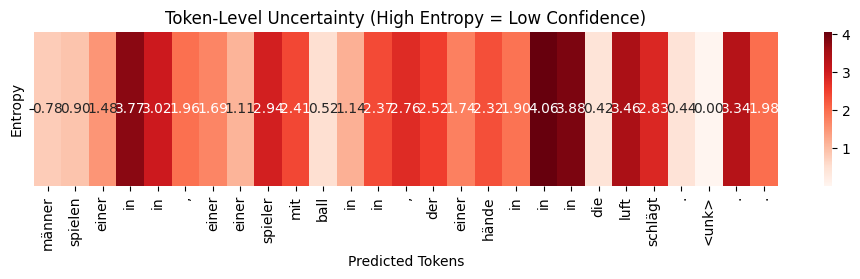

In [41]:
#  Interpretability: Entropy Heatmap 

print(f"\n{'='*60}")
print("3. Interpretability: Visualizing Prediction Uncertainty (Entropy)")
print(f"{'='*60}")

model_base.eval()
with torch.no_grad():
    src_t = worst_case['src_ids'].unsqueeze(0).to(DEVICE)
    trg_t = worst_case['trg_ids'].unsqueeze(0).to(DEVICE)
    
    # Forward pass
    logits = model_base(src_t, trg_t[:, :-1])  # [1, Seq, Vocab]
    probs = torch.softmax(logits, dim=-1)
    
    # Calculate Entropy per token: -sum(p * log(p))
    token_entropies = -(probs * torch.log(probs + 1e-9)).sum(dim=-1).squeeze().cpu().numpy()

# Prepare data for heatmap
tokens = worst_case['hyp_tokens']
display_len = min(len(tokens), len(token_entropies))
tokens = tokens[:display_len]
entropy_data = token_entropies[:display_len]

plt.figure(figsize=(12, 2))
sns.heatmap(
    [entropy_data], annot=True, fmt=".2f",
    xticklabels=tokens,
    yticklabels=['Entropy'],
    cmap='Reds', cbar=True
)
plt.title("Token-Level Uncertainty (High Entropy = Low Confidence)")
plt.xlabel("Predicted Tokens")
plt.show()



4. Interpretability: Attention Visualization (Encoder Self-Attention)


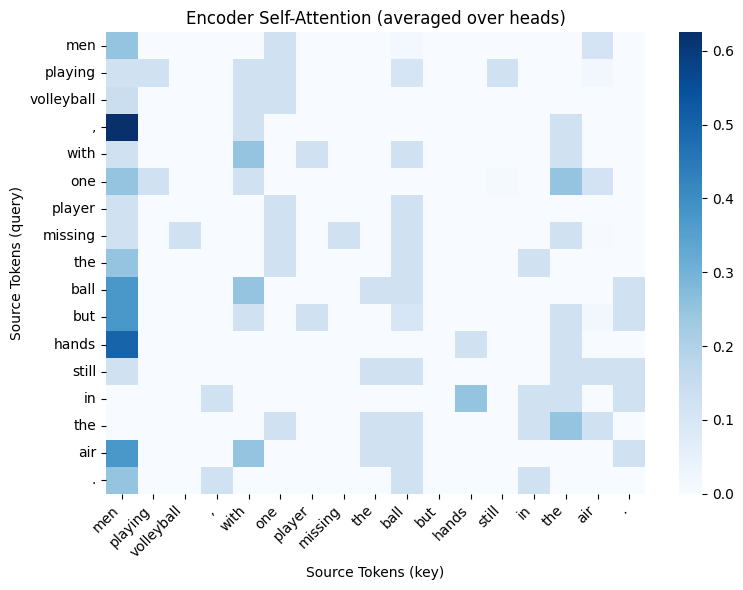

Mean attention entropy over source positions: 1.2833069562911987


In [42]:
# Attention Visualization (Encoder Self-Attention)

print(f"\n{'='*60}")
print("4. Interpretability: Attention Visualization (Encoder Self-Attention)")
print(f"{'='*60}")

inv_src = inv_vocab(vocab_src)

src_ids = worst_case["src_ids"].unsqueeze(0).to(DEVICE)
attn_weights = model_base.get_attention_weights(src_ids)  # [1, S, S]

if attn_weights is None:
    print("⚠️ Could not capture attention weights.")
else:
    attn = attn_weights[0].cpu().numpy()  # [S, S]

    # Decode source tokens for axes (strip pads/specials)
    src_tokens_full = decode_ids(worst_case["src_ids"], inv_src)
    S = min(len(src_tokens_full), attn.shape[0])
    src_tokens = src_tokens_full[:S]

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        attn[:S, :S],
        xticklabels=src_tokens,
        yticklabels=src_tokens,
        cmap="Blues",
    )
    plt.xlabel("Source Tokens (key)")
    plt.ylabel("Source Tokens (query)")
    plt.title("Encoder Self-Attention (averaged over heads)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Optional: attention entropy per query token = sharpness
    attn_torch = torch.tensor(attn[:S, :S])
    attn_entropy = -(attn_torch * torch.log(attn_torch + 1e-10)).sum(dim=-1)
    print("Mean attention entropy over source positions:", attn_entropy.mean().item())



5. Interpretability: Integrated Gradients (Source Attribution)


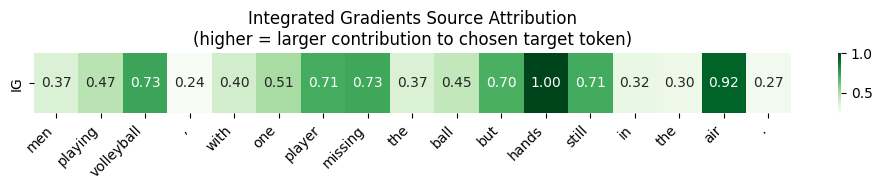

In [43]:
#  Integrated Gradients Source Attribution – Question 5b

print(f"\n{'='*60}")
print("5. Interpretability: Integrated Gradients (Source Attribution)")
print(f"{'='*60}")

try:
    ig_scores = integrated_gradients_src(
        model_base,
        worst_case["src_ids"],
        worst_case["trg_ids"],
        target_pos=-1,   # explain last decoder target
        steps=20,
        device=DEVICE,
    )

    # Align with non-special tokens for display
    src_id_list = worst_case["src_ids"].tolist()
    inv_src = inv_vocab(vocab_src)
    src_tokens = []
    src_scores = []
    for idx, score in zip(src_id_list, ig_scores.cpu().tolist()):
        if idx in [0, 1, 2]:  # skip pad/sos/eos
            continue
        src_tokens.append(inv_src.get(idx, f"<unk:{idx}>"))
        src_scores.append(score)

    src_scores = np.array(src_scores)
    if src_scores.max() > 0:
        src_scores_norm = src_scores / src_scores.max()
    else:
        src_scores_norm = src_scores

    plt.figure(figsize=(10, 2))
    sns.heatmap(
        [src_scores_norm],
        annot=True,
        fmt=".2f",
        xticklabels=src_tokens,
        yticklabels=["IG"],
        cmap="Greens",
        cbar=True,
    )
    plt.title("Integrated Gradients Source Attribution\n(higher = larger contribution to chosen target token)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("⚠️ Integrated Gradients failed:", e)

